# Exercise 1:

We now consider the following system of Differential Equations simulating a chemical reaction:

\begin{align*}
y_1' = -0.04y_1 + 10^4 y_2 y_3 \\
y_2' = 0.04 y_1 - 10^4 y_2y_3 - 3*10^7 y_2^2 \\
y_3' = 3*10^7 y_2^2
\end{align*}

with $y_1(0) = 1,y_2(0) = y_3(0) = 0$.

We use the implicit Euler Method with step size $h=0.1$ and $h=0.01$ and the embedded RK3(2) method with relative lokale Tolerance of $tol=0.01$ and $tol=1e-4$ 

Compare the numerical approximation to the time $t=0.3$ the exact solution at this point is 

$y_2(0.3) = 3.074626578578934 ·10−5$

## Implicit Euler Method

We also used this method on the last exercise sheet just to summarize the method. A general implicit Runge-Kutte method is given by

\begin{align*}
Y_i' = f(x_0 + c_ih, Y_i) \\
Y_i = y_0 + h \sum_{j=1}^s a_{ij} Y_j' ~  ~ ~ i=1,...,s \\
y_1 = y_0 + h \sum_{j=1}^s b_j Y_j'
\end{align*}

where $Y_i$ are the approximations of the function at the next time step, $f$ is the function we want to solve, $c_i$ are the coefficients of the method, $a_{ij}$ and $b_j$ are the coefficients of the method.


**Butcher Tableu of the implicit Euler Method:**

\begin{align*}
\begin{pmatrix}
1 &  |  & 1 \\
- & | & 1 
\end{pmatrix}
\end{align*}


In [59]:
import numpy as np
from scipy.optimize import newton
import matplotlib.pyplot as plt

def implicit_euler_system(f,y0,t_range,h,tol=1e-8,max_iter=100):
    """ 
    Solves y' = f(t,y) using the implicit Euler method. 

    Parameters
    ----------
    f : callable
        The function defining the system of ODEs.
    y0 : array_like
        Initial condition for the system of ODEs.
    t_range : tuple
        The time range for the solution (start, end).
    h : float
        The time step size.
    tol : float, optional
        Tolerance for the Newton's method convergence (default is 1e-8).
    max_iter : int, optional
        Maximum number of iterations for Newton's method (default is 100)

    """
    t0, t_end = t_range
    t = np.arange(t0, t_end + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0

    for n in range(len(t)- 1):
        t_n = t[n]
        t_n1 = t[n+1]

        def G(y_guess):
            return y_guess - y[n] - h*f(t_n1,y_guess)
        
        # Make initial guess using explicit Eueler step
        y_guess = y[n] + h*f(t_n, y[n])

        try:
            # Apply Newton's method to find the root of G
            y[n+1] = newton(G, y_guess, tol=tol, maxiter=max_iter)
        except RuntimeError:
            print(f"Newton's didnt_converge at n={n}, t={t_n}")
            y[n+1] = y[n]

    return t, y

def chemical_reaction(t,y):
    """ 
    Defines the system of ODEs for the chemical reaction
    """

    y1,y2,y3 = y
    dy1 = -0.04*y1 + 1e4*y2*y3
    dy2 = 0.04*y1 - 1e4*y2*y3 - 3e7*y2**2
    dy3 = 3e7*y2**2
    return np.array([dy1, dy2, dy3])

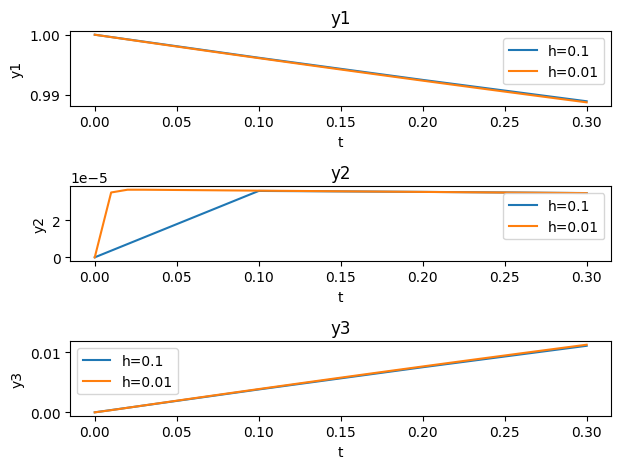

Results at t=0.3:
Exact value of y2 at t=0.3: 0.0003074626578578934
Implicit Euler with h=0.1: 3.451227809684927e-05


In [60]:
# Define the initial conditions and parameters
y0 = np.array([1.0, 0.0, 0.0])

t_range = (0.0, 0.3)
h_values = [0.1,0.01]

results = {}

for h in h_values:
    t, y = implicit_euler_system(chemical_reaction, y0, t_range, h)

    results[f"h={h}"] = {"t": t, "y": y}
    # Plot each component of y

    plt.subplot(3,1,1)
    plt.plot(t, y[:,0], label=f"h={h}")
    plt.title("y1")
    plt.xlabel("t")
    plt.ylabel("y1")
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(t, y[:,1], label=f"h={h}")
    plt.title("y2")
    plt.xlabel("t")
    plt.ylabel("y2")
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(t, y[:,2], label=f"h={h}")
    plt.title("y3")
    plt.xlabel("t")
    plt.ylabel("y3")
    plt.legend()
plt.tight_layout()
plt.show()
    


exact_value_y2_03 =3.074626578578934*10e-5

# print results at t=0.3
print("Results at t=0.3:")
print(f"Exact value of y2 at t=0.3: {exact_value_y2_03}")
print(f"Implicit Euler with h=0.1: {results['h=0.1']['y'][-1][1]}")





### Runge-Kutta 3(2) Method


We obtain the following weights when using the embedded RK3(2) method:

\begin{align*}
b_i = 1/4, 0 , 3/4 \\
\hat{b}_i = 0, 1/2, 1/2 \\
d_i = -1/4, 1/2, -1/4
\end{align*}

together with this algorithm:

```{text}
if est \leq tol then
    x_0 := x_0 + h
    y_0 := y1
    h := min(h_opt, bar_x - x_0)
else
   make step again with h=h_opt

if x_0 = bar_x then stop
```

In [71]:
def rk32_adaptive_sytem(f,y0,t_range,tol=1e-6,h_min=1e-6,h_max=0.1,max_steps=10000):
    """ 
    Performs adaptive RK(3)2 method for solving ODEs.

    b_i = [1/4, 0, 3/4]
    b_i_hat =[0,1/2,1/2]
    d_i = [-1/4,1/2,-1/4]
    """
    t0, t_end = t_range
    t = [t0]
    y = [np.array(y0)]
    h = h_max
    h_history = [h]

    steps = 0
    while t[-1] < t_end and steps < max_steps:
        steps += 1
        if t[-1] + h > t_end:
            h = t_end - t[-1]

        tn = t[-1]
        yn = y[-1]

        # Determine the k's or the steps so to say
        k1 = f(tn, yn)
        k2 = f(tn + 0.5*h, yn + 0.5*h*k1)
        k3 = f(tn + h, yn-h*k1 + 2*h*k2)

        # Compute both y1 and yhat
        y1 = yn + h*(0.25*k1 + 0.75 * k3)
        y1_hat = yn + h*(0.5*k2 + 0.5*k3)

        # Make error estimate
        est = np.linalg.norm(y1-y1_hat)

        
        # Step size adjustment
        if est <= tol:
            t.append(tn + h)
            y.append(y1)

            # Maybe try the better formula given in Bemerkung
            a = 6
            b = 0.2
            h_opt = h*min(a,max(b,(0.9*tol/est)**(1/3)))

            h = min(h_opt, h_max)

            #h = min(h_max,0.9*h*(tol/est)**(1/3))
            h_history.append(h)
        else:
            # Set h=h_opt
            h = min(h_min,0.9*h*(tol/est)**(1/3))
    return np.array(t), np.array(y), np.array(h_history)


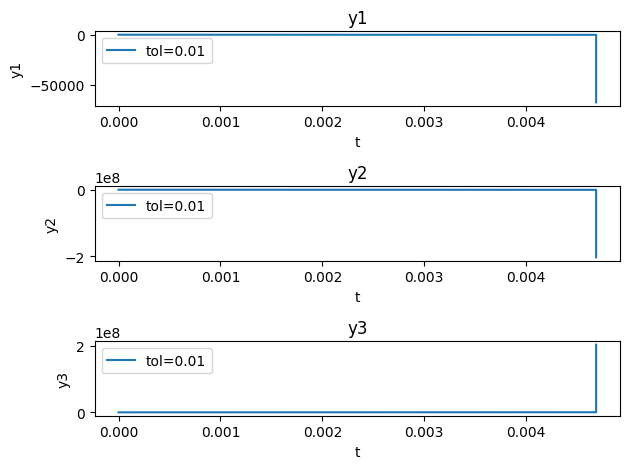

Final step size for tol=0.01: 4.9943699627530976e-20


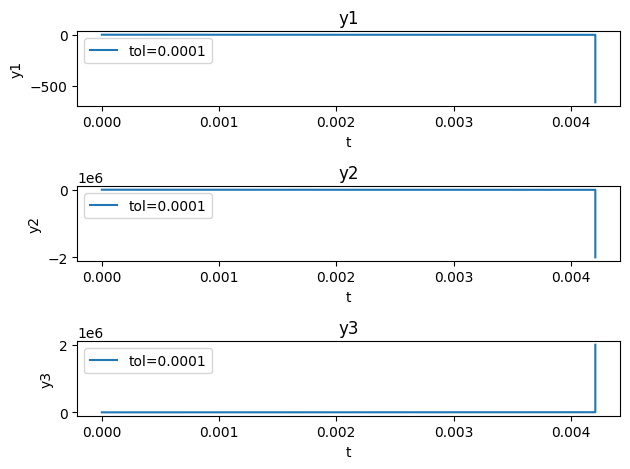

Final step size for tol=0.0001: 5.088855663951593e-18


In [72]:
results = {}

for tol in [0.01,1e-4]:
    t, y, h_history = rk32_adaptive_sytem(chemical_reaction, y0, t_range, tol=tol)
    results[f"tol={tol}"] = {"t": t, "y": y, "h_history": h_history}
    #plot each component of y
    plt.subplot(3,1,1)
    plt.plot(t, y[:,0], label=f"tol={tol}")
    plt.title("y1")
    plt.xlabel("t")
    plt.ylabel("y1")
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(t, y[:,1], label=f"tol={tol}")
    plt.title("y2")
    plt.xlabel("t")
    plt.ylabel("y2")
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(t, y[:,2], label=f"tol={tol}")
    plt.title("y3")
    plt.xlabel("t")
    plt.ylabel("y3")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Final step size for tol={tol}: {h_history[-1]}")
    


In [66]:
# Print exact results and adaptive RK(3)2 results
print("Results at t=0.3:")
print(f"Exact value of y2 at t=0.3: {exact_value_y2_03}")
print(f"Adaptive RK(3)2 with tol=0.01: {results['tol=0.01']['y'][-1][1]}")

Results at t=0.3:
Exact value of y2 at t=0.3: 0.0003074626578578934
Adaptive RK(3)2 with tol=0.01: -2367222.3806613125


# Exercise 2:

We now solve the IVP

\begin{align*}
y' = 10(y- \frac{x^2}{x^2 + 1})+\frac{2x}{(x^2 + 1)^2} \\
y(0) = 0
\end{align*}

we want to use Trapezoidal rule, implicit Euler and RK4 method with 100 steps on [0,3] and compare the results

In [73]:
def f(x,y):
    return 10*(y- x**2/(x**2 + 1)) + 2*x/((x**2+1)**2)


x0,x_end = 0,3
n_steps = 1000
h = (x_end-x0)/n_steps
x_points = np.linspace(x0,x_end,n_steps+1)

# Initial conditions
y0 = 0


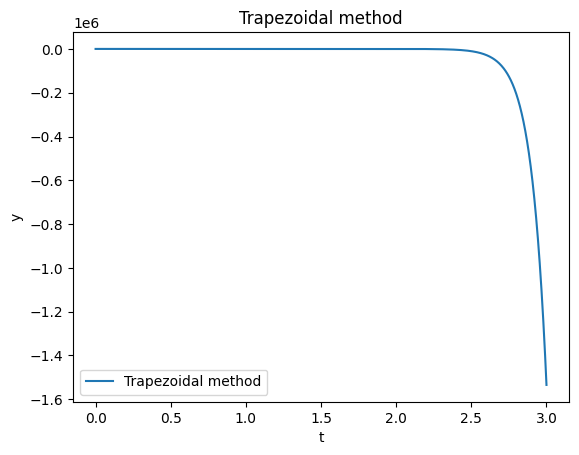

In [74]:
from scipy.optimize import root


def trapezoidal(f,t0,y0,h,n_steps):
    """ 
    Solve the IVP using Trapezoidal method a two step method

    
    Butcher tableau:
    0 | 0   0
    1 | 1/2  1/2
    - | 1/2  1/2
    """
    t= np.zeros(n_steps+1)
    y = np.zeros(n_steps+1)
    t[0] = t0
    y[0] = y0

    for i in range(n_steps):
        t_curr = t[i]
        y_curr = y[i]

        # Define the state equation
        def F(Y1):
            return Y1 - y_curr - h/2*(f(t_curr,y_curr) + f(t_curr + h,Y1))
        
        # Initial guess using explicit Euler step
        y_guess = y_curr + h*f(t_curr,y_curr)

        # Solve the equation using root finding
        sol = root(F, y_guess,method='hybr') 
        Y1 = sol.x[0]

        # Update step
        y_next = Y1
        
        # Store the results
        t[i+1] = t_curr + h
        y[i+1] = y_next
    return t, y

# Solve the ODE using the trapezoidal method
t, y = trapezoidal(f,x0,y0,h,n_steps)
# Plot the results
plt.plot(t, y, label='Trapezoidal method')
plt.title("Trapezoidal method")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()


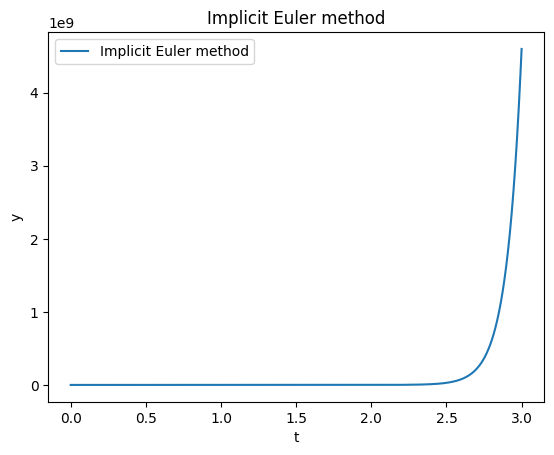

In [75]:
def implicit_euler(f,t0,y0,h,n_steps):
    """ 
    Solve the IVP using implicit Euler method
    """
    t= np.zeros(n_steps+1)
    y = np.zeros(n_steps+1)
    t[0] = t0
    y[0] = y0

    for i in range(n_steps):
        t_curr = t[i]
        y_curr = y[i]

        # Define the state equation
        def F(Y1):
            return Y1 - y_curr - h*f(t_curr + h,Y1)
        
        # Initial guess using explicit Euler step
        y_guess = y_curr + h*f(t_curr,y_curr)

        # Solve the equation using root finding
        sol = root(F, y_guess,method='hybr') 
        Y1 = sol.x[0]

        # Update step
        y_next = Y1
        
        # Store the results
        t[i+1] = t_curr + h
        y[i+1] = y_next
    return t, y

# Solve the ODE using the implicit Euler method
t, y = implicit_euler(f,x0,y0,h,n_steps)
# Plot the results
plt.plot(t, y, label='Implicit Euler method')
plt.title("Implicit Euler method")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

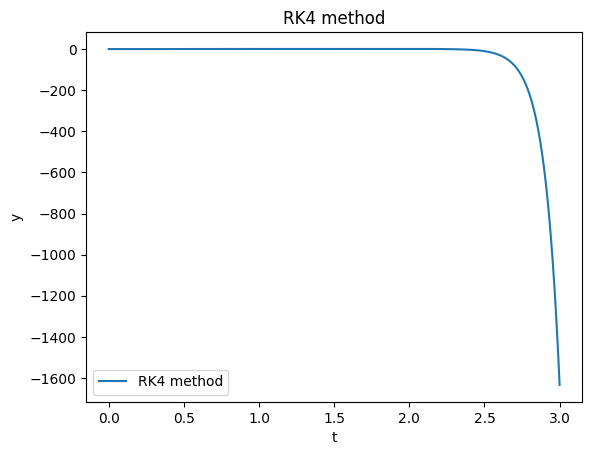

In [76]:
def rk4(f,t0,y0,dt,num_steps):
    """
    Runge-Kutta method of order 4 for solving ODEs.
    
    Parameters:
    f : function
        The function defining the ODE dy/dt = f(t, y).
    t0 : float
        Initial time.
    y0 : float
        Initial value of y at t0.
    dt : float
        Time step size.
    num_steps : int
        Number of steps to take.
    """
    t = np.zeros(num_steps + 1)
    y = np.zeros(num_steps + 1)
    
    t[0] = t0
    y[0] = y0
    
    for i in range(num_steps):
        k1 = f(t[i], y[i])
        k2 = f(t[i] + dt / 2, y[i] + (dt / 2) * k1)
        k3 = f(t[i] + dt / 2, y[i] + (dt / 2) * k2)
        k4 = f(t[i] + dt, y[i] + dt * k3)
        y[i + 1] = y[i] + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        t[i + 1] = t[i] + dt
    
    return t, y

# Solve the ODE using the RK4 method
t, y = rk4(f,x0,y0,h,n_steps)
# Plot the results
plt.plot(t, y, label='RK4 method')
plt.title("RK4 method")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

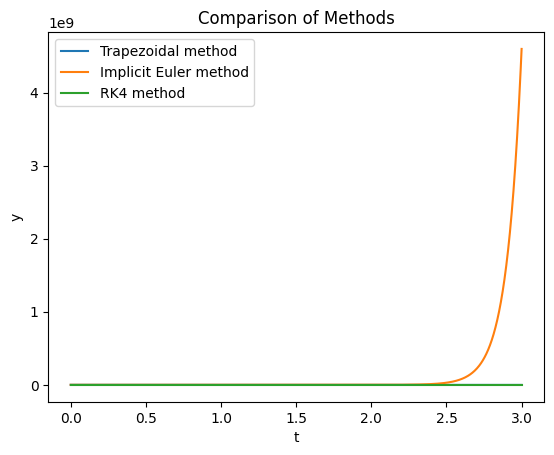

In [77]:
# Plot all the results together
t_trapezoidal, y_trapezoidal = trapezoidal(f,x0,y0,h,n_steps)
t_implicit, y_implicit = implicit_euler(f,x0,y0,h,n_steps)
t_rk4, y_rk4 = rk4(f,x0,y0,h,n_steps)
plt.plot(t_trapezoidal, y_trapezoidal, label='Trapezoidal method')
plt.plot(t_implicit, y_implicit, label='Implicit Euler method')
plt.plot(t_rk4, y_rk4, label='RK4 method')
plt.title("Comparison of Methods")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()